# Import Packages 

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import warnings

from scipy import stats
from ipywidgets import interact
from scipy.stats.mstats import winsorize


# Connect to Data

In [2]:
# =============================================================================
# 1. Import data
# =============================================================================

file_path = "C:/Users/Yi Ting/Desktop/Studies/Github/Car_Failure/failure.xlsx"
df = pd.read_excel(file_path, header = 0)

#check dataframe
df.head()

,Unnamed: 0,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0


In [3]:
#Identify data types
df.dtypes


Unnamed: 0            int64
Car ID               object
Model                object
Color                object
Temperature          object
RPM                   int64
Factory              object
Usage                object
Fuel consumption    float64
Membership           object
Failure A             int64
Failure B             int64
Failure C             int64
Failure D             int64
Failure E             int64
dtype: object

From the display of data and datatypes, temperature can be classified as float but need to remove the unit of measurement.  
The rest of the data types are correct.

# Data Cleaning

Print unique value in each categorical data to check for data consistency.   
Resuls: inconsistent data entry in "Factory"; missing data in "Membership"


In [4]:
# =============================================================================
# 3. Data cleaning
# =============================================================================

#3(i) Check for data inconsistency in categorical data - Model, Color, Factory, Usage, Fuel Consumption and Membership

categorical_data = ['Model', 'Color', 'Factory', 'Usage', 'Membership']

def check_data_entry(data, col):
    for i in col:
        print(i)
        print(set(df[i]))

check_data_entry(df,categorical_data)
#result: inconsistent data entry in "Factory", missing data in "Membership"

#Cleaning inconsistent data entry in 'Factory'.
df['Factory'] = df['Factory'].replace({
    'Newton, China':'New York, U.S', 
    'Seng Kang, China':'Shang Hai, China',  
    'Bedok, Germany':'Berlin, Germany'
    })


Model
{'Model 7, 2014', 'Model 3, 2017', 'Model 5, 2022', 'Model 7, 2010', 'Model 3, 2010', 'Model 5, 2021', 'Model 3, 2020', 'Model 7, 2019', 'Model 5, 2012', 'Model 3, 2021', 'Model 5, 2013', 'Model 3, 2014', 'Model 7, 2016', 'Model 5, 2015', 'Model 7, 2020', 'Model 7, 2011', 'Model 3, 2013', 'Model 3, 2016', 'Model 7, 2013', 'Model 5, 2019', 'Model 7, 2022', 'Model 7, 2015', 'Model 7, 2018', 'Model 5, 2011', 'Model 5, 2017', 'Model 5, 2009', 'Model 3, 2022', 'Model 3, 2011', 'Model 5, 2010', 'Model 5, 2014', 'Model 7, 2021', 'Model 5, 2018', 'Model 3, 2019', 'Model 3, 2012', 'Model 7, 2012', 'Model 5, 2020', 'Model 5, 2016', 'Model 7, 2017', 'Model 3, 2015', 'Model 3, 2018', 'Model 3, 2009'}
Color
{'Grey', 'Blue', 'White', 'Black', 'Red'}
Factory
{'Berlin, Germany', 'Newton, China', 'New York, U.S', 'Bedok, Germany', 'Shang Hai, China', 'Seng Kang, China'}
Usage
{'Medium', 'Low', 'High'}
Membership
{'Normal', 'Premium', 'None', nan}


In [5]:
print("After cleaning data-inconsistency in Factory column, the unique values are: {}".format(str(set(df.Factory))))


After cleaning data-inconsistency in Factory column, the unique values are: {'Shang Hai, China', 'Berlin, Germany', 'New York, U.S'}


Check for data inconsistency inconsistency in Temperature column. 
Result: There are 2 units of measurement in the data- degree celcius and farenheit;  
need to change Farenheit to degree celcius for data consistency in unit of measurement

In [6]:
#3(ii) Data inconsistency in Temperature column- change farenheit to degree celcius. Change column to quantity data type. 

print(set(df["Temperature"]))

#Split Temperature from unit of measurement
df[['Temperature2', 'Temperature_units']] = df["Temperature"].str.split(" ", expand=True)

#Remove white space in the split Temperature2 and change type to float 
df['Temperature2'].str.strip()
df['Temperature2'] = df['Temperature2'].astype(float)

#Remove °, easier to type
df['Temperature_units'] = df['Temperature_units'].str[-1:]

# Farenheit to degree celcius formula: (32°F − 32)*(5/9) = 0°C
def farenheit_to_celcius(x):
    return (x-32)*(5/9)

#Changing Farenheit to Degree celcius by slicing: if measurement_unit is farenheit, apply farenheit to celcius formula 
celcius_condition = df['Temperature_units'] == 'C'
df.loc[celcius_condition,'Temperature']= df.Temperature2

farenheit_condition = df['Temperature_units'] == 'F'
df.loc[farenheit_condition,'Temperature']= farenheit_to_celcius(df.Temperature2)

#round Temperature column to 1d.p.
df['Temperature'] = df['Temperature'].apply(lambda x: round(x,1))

#drop previously split column - Temperature2 and Temperature_unit
df.drop(['Temperature2', 'Temperature_units'], axis=1, inplace=True)

{'117.2 °C', '121.6 °C', '111.7 °C', '125.4 °C', '255.8 °F', '266.5 °F', '232.6 °F', '230.3 °F', '230.8 °F', '235.6 °F', '113.8 °C', '230.1 °F', '124.3 °C', '231.9 °F', '271.9 °F', '238.5 °F', '231.4 °F', '123.4 °C', '230.7 °C', '230.2 °F', '120.9 °C', '236.5 °F', '111.9 °C', '230.7 °F', '235.2 °F', '110.9 °C', '110.2 °C', '111.2 °C', '118.2 °C', '131.7 °C', '274.9 °F', '237.4 °F', '114.4 °C', '243.8 °F', '233.0 °F', '245.9 °F', '110.1 °C', '112.2 °C', '112.7 °C', '264.1 °F', '231.1 °F', '232.1 °F', '237.9 °F', '240.5 °F', '278.2 °F', '110.8 °C', '232.0 °F', '230.6 °F', '111.3 °C', '116.2 °C', '112.4 °C', '112.5 °C', '234.0 °F', '231.0 °F', '234.3 °F', '232.8 °F', '111.4 °C', '110.3 °C', '241.2 °F', '242.0 °F', '118.8 °C', '110.7 °C', '230.9 °F', '248.3 °F', '231.5 °F', '230.5 °F', '112.9 °C', '113.6 °C', '114.7 °C', '269.1 °F', '230.4 °F', '232.4 °F', '110.6 °C', '115.4 °C', '247.0 °F', '249.6 °F', '111.1 °C', '251.0 °F', '127.7 °C', '120.1 °C', '110.0 °C', '111.5 °C', '242.9 °F', '23

# Feature Engineering
separate year from model
create predictor column indicating failure (Y/N)  
Create a column for type of failure for analysis and plots

In [7]:
# =============================================================================
# 3. Feature engineering
# =============================================================================

#3(i) Separate year produced from model
df[['Model', 'Year_released']] = df["Model"].str.split(",", expand=True)




In [8]:
#3(ii) create a predictor column indicating failure (Y/N) and a column for the type of failure for analysis and plots 

failure_col = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']

def failure_identification(data, col):
    data['Failure'] = 'N' #create new column and assume all N
    #create new column and assume no failure type
    data['Failure_type'] = "None" 
    #search all failure type and indicate Y if failure and type
    for i in col:
        fail_condition = (data[i] == 1)     
        data.loc[fail_condition, 'Failure'] = "Y" #there is failure
        data.loc[fail_condition, 'Failure_type'] = i #failure type 
    return data


failure_identification(df, failure_col)





,Unnamed: 0,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Year_released,Failure,Failure_type
0,0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,Blue,110.3,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,2022,N,None
1,1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,Black,110.4,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,2022,Y,Failure A
2,2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,Grey,110.3,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,2022,N,None
3,3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,Black,110.4,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,2022,Y,Failure A
4,4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,White,230.7,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,2022,Y,Failure B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076,10076,64921ab7-c024-447a-8651-006a7e8a5e64,Model 5,White,110.6,1575,"Shang Hai, China",Low,728.5,Premium,0,0,0,0,0,2020,N,None
10077,10077,246aa846-094d-441a-814a-ecf64d4e3775,Model 5,White,110.6,1750,"Berlin, Germany",Low,698.9,Premium,0,0,0,0,0,2020,N,None
10078,10078,0b9c5542-e343-4b7e-a4c9-aad358dbe993,Model 3,White,110.6,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0,2019,N,None
10079,10079,fd5ac6de-3afb-4ad8-b4a9-4bc47b34dd08,Model 3,Blue,110.6,1523,"Berlin, Germany",High,638.8,Premium,0,0,0,0,0,2019,N,None


# Missing data 
Check if missing data is random against our primary variable of interest - Failure Y/N
Result:   
Data seems to be not missing at random. Undisclosed membership type all resulted in failure.  
Filling the missing value with mode would likely skew the category type towards failure - Y   
Thus, recommend to keep the missing data as a type by itself - undisclose  

In [9]:
# =============================================================================
# 4. Missing data
# =============================================================================

df.isna().sum() #384 missing data in membership



Unnamed: 0            0
Car ID                0
Model                 0
Color                 0
Temperature           0
RPM                   0
Factory               0
Usage                 0
Fuel consumption      0
Membership          384
Failure A             0
Failure B             0
Failure C             0
Failure D             0
Failure E             0
Year_released         0
Failure               0
Failure_type          0
dtype: int64

In [10]:
#Check if missing data is random against our primary variable of interest - Failure Y/N
#Create a new column to indicate if it is missing
df['Missing'] = 0
df.loc[df[df['Membership'].isnull()].index, 'Missing'] = 1
#check number of missing data against Failure
df[df['Missing']==1].groupby('Failure')['Missing'].count()


#change missing data as undisclose
df.loc[df[df['Membership'].isnull()].index , 'Membership'] = 'Undisclose' 

# Outlier

Based on the result, there seem to be outlier in Temperature and RPM  from the mean and max/min value comparison.  
From the boxplot, there is an extreme outlier in Temperature. Since it is only 1 row, it would not affect whole data and will be removed.   
RPM cannot be negative, it would be remove since is 224/10081 = 0.02% of the data  


In [11]:
# =============================================================================
# 5. Outlier
# =============================================================================
df.describe()
#Based on the result, there seem to be outlier in Temperature and RPM  from the mean and max/min value comparison
#From the boxplot, there is an extreme outlier in Temperature. Since it is only 1 row, it would not affect whole data
#Thus, would be removed
#RPM cannot be negative, it would be remove since is 224/10081 = 0.02% of the data



,Unnamed: 0,Temperature,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Missing
count,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000
mean,5040.000000,113.098363,1470.626823,679.472304,0.025692,0.018550,0.031049,0.024502,0.026386,0.038091
std,2910.278366,4.657374,487.502419,58.486101,0.158222,0.134935,0.173457,0.154608,0.160289,0.191427
min,0.000000,110.000000,-2636.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2520.000000,110.400000,1418.000000,638.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5040.000000,111.300000,1499.000000,668.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7560.000000,113.600000,1609.000000,704.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10080.000000,230.700000,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#function to detect outlier based on IQR
def find_outliers_IQR(df):
   q1 = df.quantile(0.25)
   q3 = df.quantile(0.75)
   IQR = q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

#find number of outlier: temperature -930
continuous_col = ['Temperature', 'RPM', 'Fuel consumption']

#function to count number of outlier based on IQR

def outlier_count(data, col):
    for i in col:
        outliers = find_outliers_IQR(data[i])
        print('number of outliers in ' + str(i) + ":" + str(len(outliers)) )
       
  

#Result- Temperature: 930; RPM: 636; Fuel consumption: 578 
outlier_count(df, continuous_col)




number of outliers in Temperature:930
number of outliers in RPM:636
number of outliers in Fuel consumption:578


# Outlier - Distribution plot, histogram and probability plot

The results show a large number of outliers and skewed data
Handling of outlier should be done separtely on train dataset to not affect prediction on real data



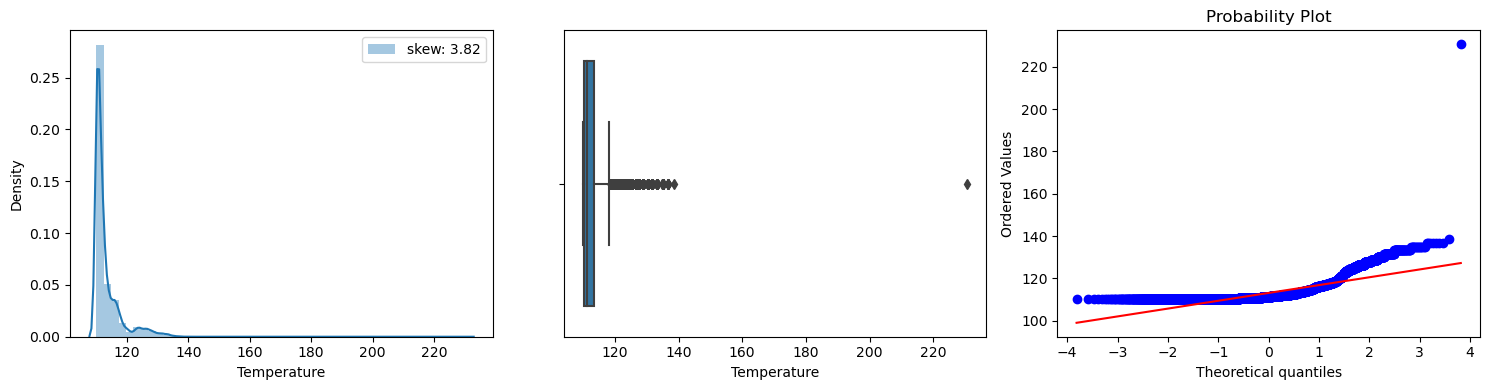

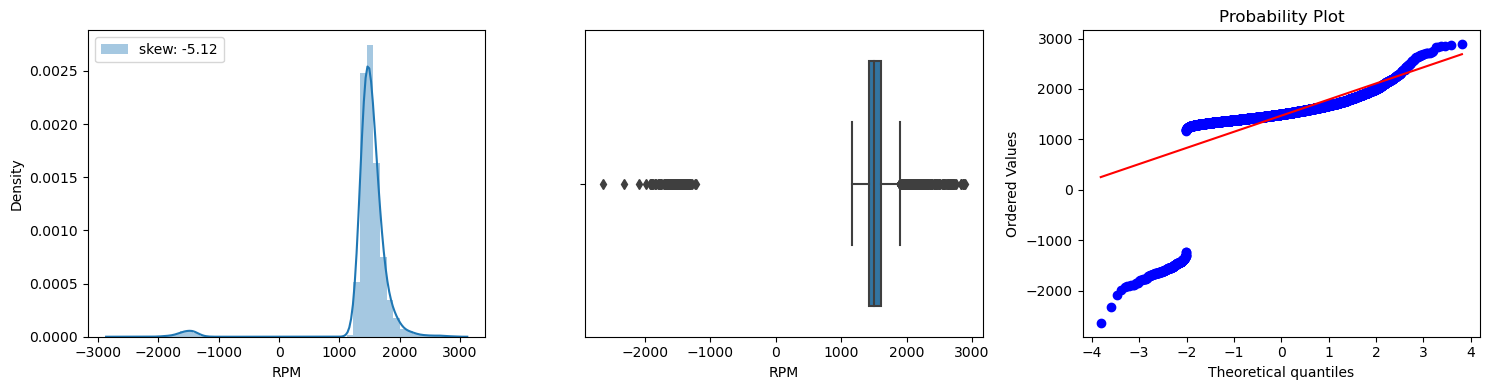

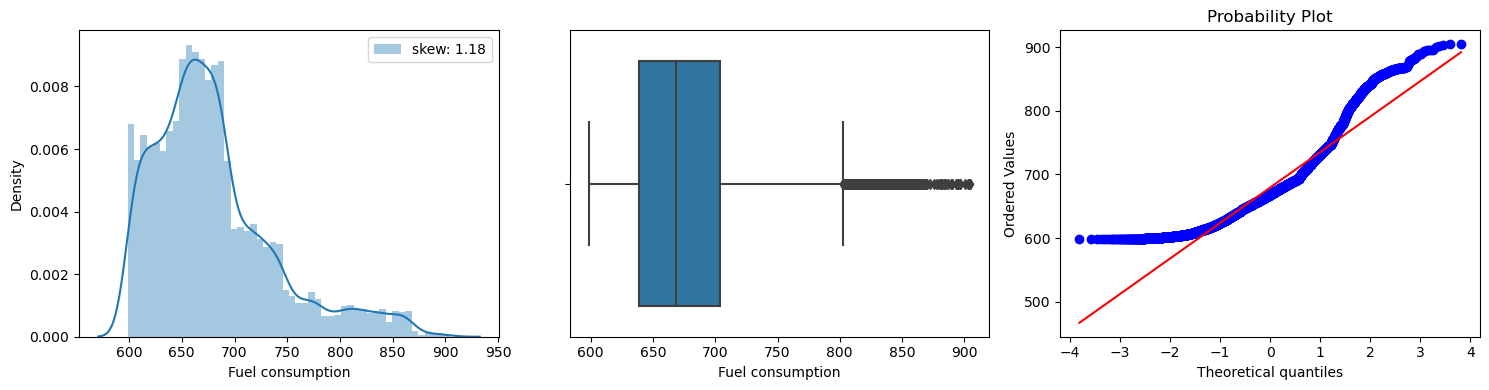

In [13]:
#Graphical view of outlier in distribution plot, histogram and probability plot

for col in continuous_col:
    warnings.simplefilter('ignore') #hide distplot function suggestion warning
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    stats.probplot(df[col], plot=plt)
    plt.tight_layout()
    plt.show()
    


    

# Heatmap - Check for correlation

result: low correlation between variables, no issue of multicollinearity

<AxesSubplot:>

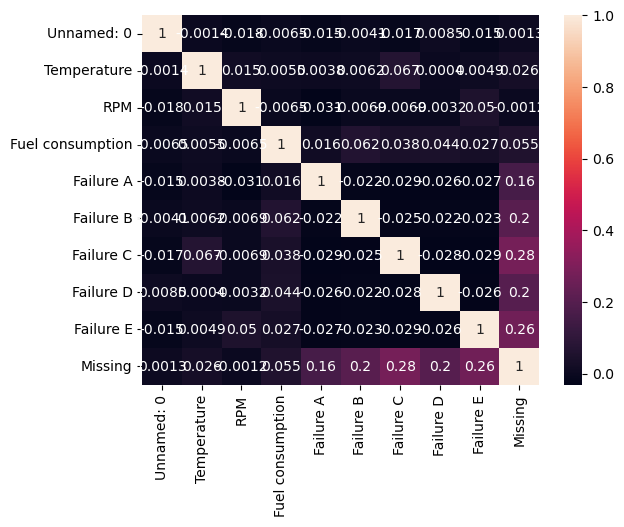

In [14]:
#plot heatmat to see if there are correlation

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)



In [15]:
#Remove temperature 230 degree outlier
df = df.drop([4], axis = 0)

#remove RPM cannot be negative
df = df[df["RPM"]>0] 

# Bar plot - Count failure (Y/N)

Barplot shows data imbalance - require balance dataset if applying machine learning. 

<AxesSubplot:xlabel='Failure', ylabel='count'>

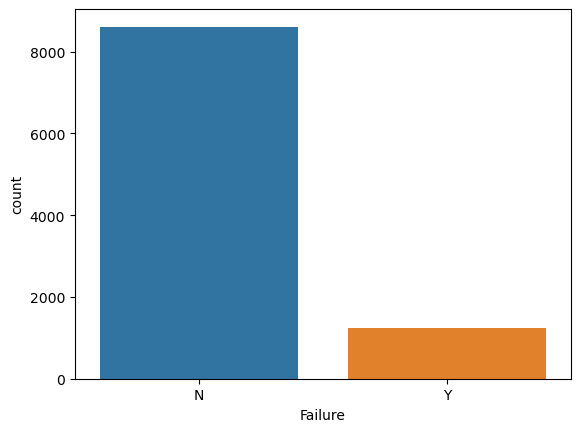

In [16]:
# =============================================================================
# 4. imbalanced data 
# =============================================================================


sns.countplot(data = df, x = 'Failure')

# Pairplot 

There are no relationship between the continuous variable.

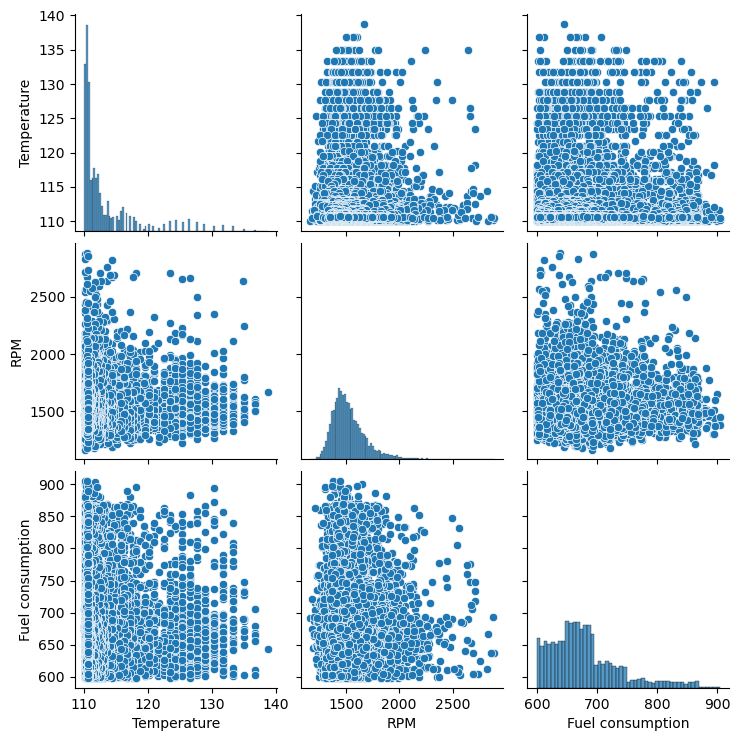

In [17]:
# =============================================================================
# 5. Exploratory Data Analysis (EDA)
# =============================================================================

col = ['Temperature', 'RPM', 'Fuel consumption']
sns.pairplot(df[col])

plt.show()

# Interactive count plots

Insights:

1. As new models come out, there are lesser data count 
2. White is the most popular colour for all three models
3. Majority of the models are produced in Shang Hai, China

4. Is there a relationship between failure and high usage? 
selecting column: Failure, hue: usage. It shows that no failure occur for all usage type proportionately.
But high usage did has a higher proportion of failure 

5. Failure type C occur the least while failure type B occur the most

6. Having premium membership does not lower failure 
possible reason: people are more careless with more repair service avaiable



In [18]:
# =============================================================================
# 6. Interactive plots
# =============================================================================

categorical_col = [column for column in df.columns if df[column].dtypes == "object"]
categorical_col.remove('Car ID')

#column
dd1 = widgets.Dropdown(
    options=categorical_col,
    value=categorical_col[0],
    description='Select column'
    )

#hue
dd2 = widgets.Dropdown(
    options=categorical_col,
    value=categorical_col[0],
    description='Hue'
    )
ui = widgets.HBox([dd1,dd2])

def plot_countplot(column, hue):
    p = sns.countplot(data=df, x=column, hue=hue)
    if len(df[column].unique()) > 4: 
        p.tick_params(axis='x', rotation=90) #rotate for readability
    for i in p.patches:
        p.annotate('{:^.0f}'.format(i.get_height()), (i.get_x(), i.get_height()))

out = widgets.interactive_output(plot_countplot, {'column': dd1, 'hue': dd2})

display(ui, out)



Output()